In [1]:
import math
import warnings
import re
import copy
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from math import sqrt
from plotly.offline import iplot
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2]:
df = pd.read_csv('LeedsHousePrices1996-2015 copy.csv', encoding='latin-1', dtype=object)

In [3]:
df.head()

,ID,PRICE,DATE OF TRANSFER,POSTCODE,PROPERTY TYPE,OLD/NEW,DURATION,PAON,SAON,STREET,LOCALITY,TOWN/CITY,DISTRICT,COUNTY,STATUS
0,{5B219636-DCA5-4E6D-937A-1AA6CF5A80DE},"£48,950",2/1/1995,BD11 1JN,S,N,F,9,NaN,WALTON DRIVE,DRIGHLINGTON,BRADFORD,LEEDS,WEST YORKSHIRE,A
1,{9814661F-EF38-4E76-BC8B-CE526C9DA243},"£95,950",2/1/1995,LS19 7WF,D,Y,F,8,NaN,BALMORAL WAY,YEADON,LEEDS,LEEDS,WEST YORKSHIRE,A
2,{E5EFA246-1804-4CF2-B82F-021CE3525116},"£58,000",3/1/1995,LS22 7RA,S,N,F,22,NaN,POPLAR AVENUE,WETHERBY,WETHERBY,LEEDS,WEST YORKSHIRE,A
3,{2359AE71-7172-45C2-B628-12FBDFEF3F1C},"£83,950",3/1/1995,LS26 9BA,D,Y,F,45,NaN,PINDERS GREEN DRIVE,METHLEY,LEEDS,LEEDS,WEST YORKSHIRE,A
4,{F817C2E1-91D3-45D5-9F7D-23074F775565},"£332,500",3/1/1995,LS17 8EP,D,N,F,626,NaN,HARROGATE ROAD,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A


In [4]:
df.isnull().sum()

ID                       0
PRICE                    0
DATE OF TRANSFER         0
POSTCODE               220
PROPERTY TYPE            0
OLD/NEW                  0
DURATION                 0
PAON                   483
SAON                254392
STREET                 137
LOCALITY             59279
TOWN/CITY                0
DISTRICT                 0
COUNTY                   0
STATUS                   0
dtype: int64

In [5]:
df.drop(columns = "ID", axis =1, inplace = True)
df.drop(columns = "PAON", axis =1, inplace = True)
df.drop(columns = "SAON", axis =1, inplace = True)
df.drop(columns = "STATUS", axis =1, inplace = True)
df.drop(columns = "STREET", axis =1, inplace = True)
df.drop(columns = "POSTCODE", axis =1, inplace = True)
df.drop(columns = "LOCALITY", axis =1, inplace = True)

In [6]:
df.count()

PRICE               273692
DATE OF TRANSFER    273692
PROPERTY TYPE       273692
OLD/NEW             273692
DURATION            273692
TOWN/CITY           273692
DISTRICT            273692
COUNTY              273692
dtype: int64

In [7]:
#Convert Date of Transfer and Extract Year and Month
df['DATE OF TRANSFER'] = pd.to_datetime(df['DATE OF TRANSFER'], format='%d/%m/%Y')

# Extract year and month:
df['Year'] = df['DATE OF TRANSFER'].dt.year
df['Month'] = df['DATE OF TRANSFER'].dt.month

#This code efficiently converts the DATE OF TRANSFER column 
#from a string format to a datetime format and then extracts 
#the year and month information into separate columns for easier 
#analysis and filtering.

In [8]:
df.head()

,PRICE,DATE OF TRANSFER,PROPERTY TYPE,OLD/NEW,DURATION,TOWN/CITY,DISTRICT,COUNTY,Year,Month
0,"£48,950",1995-01-02,S,N,F,BRADFORD,LEEDS,WEST YORKSHIRE,1995,1
1,"£95,950",1995-01-02,D,Y,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1
2,"£58,000",1995-01-03,S,N,F,WETHERBY,LEEDS,WEST YORKSHIRE,1995,1
3,"£83,950",1995-01-03,D,Y,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1
4,"£332,500",1995-01-03,D,N,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1


In [9]:
df['PRICE'] = df['PRICE'].astype(str)
df['PRICE'] = df['PRICE'].str.replace(r'[^\d\-+\.]', '', regex=True)
df['PRICE'] = pd.to_numeric(df['PRICE'])
df.groupby('Year')['PRICE'].median()

#This code cleans and prepares the PRICE data for further analysis. 
#It handles potential non-numerical entries, cleans separators, 
#and calculates the median price for each year

Year
1995     49250.0
1996     49950.0
1997     52000.0
1998     54997.5
1999     79950.0
2000     64000.0
2001     69950.0
2002     83000.0
2003    105000.0
2004    126500.0
2005    132950.0
2006    140000.0
2007    146000.0
2008    139995.0
2009    135000.0
2010    144000.0
2011    140000.0
2012    142498.0
2013    145000.0
2014    150000.0
2015    151000.0
Name: PRICE, dtype: float64

In [10]:
df.drop(columns = 'DATE OF TRANSFER', axis = 1, inplace = True)

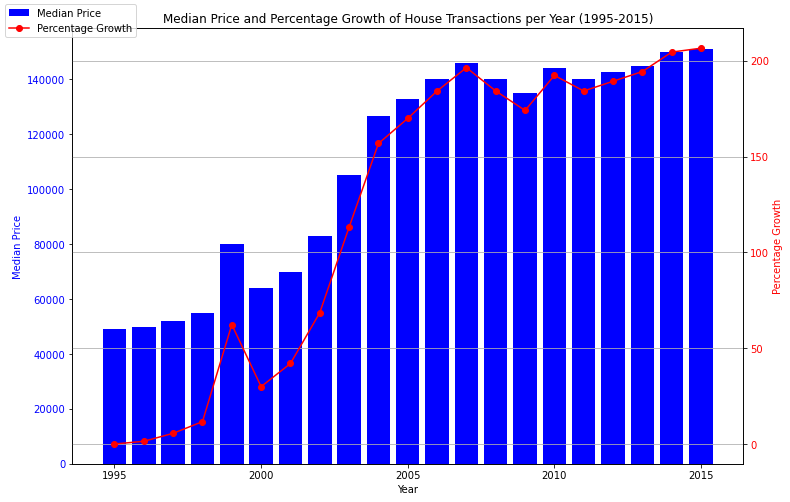

Median Price and Percentage Growth of House Transactions per Year (1995-2015)


In [11]:
# Group the data by year and calculate the median price for each year
median_prices_per_year = df.groupby('Year')['PRICE'].median()

# Calculate percentage growth from the first year
first_year_price = median_prices_per_year.iloc[0]
percentage_growth = ((median_prices_per_year - first_year_price) / first_year_price) * 100

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(11, 7))

# Plot bar chart for median prices per year
ax1.bar(median_prices_per_year.index, median_prices_per_year.values, color='b', label='Median Price')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for percentage growth
ax2 = ax1.twinx()
ax2.plot(percentage_growth.index, percentage_growth.values, color='r', marker='o', label='Percentage Growth')
ax2.set_ylabel('Percentage Growth', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legends
plt.title('Median Price and Percentage Growth of House Transactions per Year (1995-2015)')
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
fig.legend(loc='upper left')
plt.show()

print('Median Price and Percentage Growth of House Transactions per Year (1995-2015)')

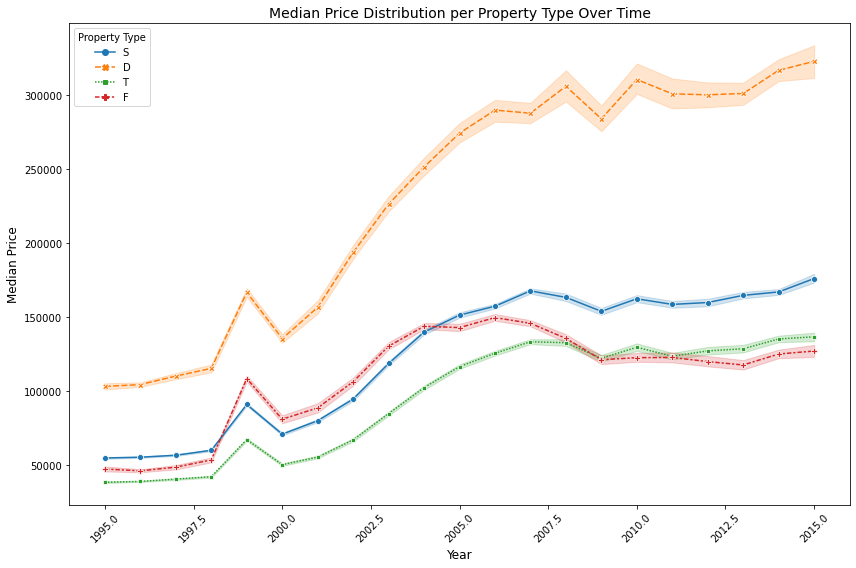

Median Price Distribution per Property Type Over Time


In [12]:
# Create a line plot for median price distribution per property type
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Year', y='PRICE', hue='PROPERTY TYPE', style='PROPERTY TYPE', markers=True)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Price', fontsize=12)
plt.title('Median Price Distribution per Property Type Over Time', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.legend(title='Property Type')
plt.tight_layout()
plt.show()

print('Median Price Distribution per Property Type Over Time')

In [13]:
print(df.shape)

(273692, 9)


In [14]:
#One-hot Encoding Applied to Property Type
PROPERTY_TYPE = ('D','S','F','T')

enc_df = pd.DataFrame(df, columns = ['PROPERTY TYPE'])

dum_df = pd.get_dummies(df, columns = ["PROPERTY TYPE"], prefix = ["Property_Type_"] )

df = enc_df.join(dum_df)

df.drop(columns = 'PROPERTY TYPE', axis = 1, inplace = True)

df

,PRICE,OLD/NEW,DURATION,TOWN/CITY,DISTRICT,COUNTY,Year,Month,Property_Type__D,Property_Type__F,Property_Type__S,Property_Type__T
0,48950,N,F,BRADFORD,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
1,95950,Y,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
2,58000,N,F,WETHERBY,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
3,83950,Y,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
4,332500,N,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
273687,90000,N,F,LEEDS,LEEDS,WEST YORKSHIRE,2015,8,0,0,0,1
273688,130000,N,F,LEEDS,LEEDS,WEST YORKSHIRE,2015,8,0,0,1,0
273689,220000,N,F,WETHERBY,LEEDS,WEST YORKSHIRE,2015,8,0,0,1,0
273690,174000,N,F,LEEDS,LEEDS,WEST YORKSHIRE,2015,8,0,0,0,1


In [15]:
#Apply Label encoding on Old/New (N - 0, Y - 1)
encoder = LabelEncoder()

encoder.fit(df['OLD/NEW'])

df['OLD/NEW'] = encoder.transform(df['OLD/NEW'])

df.head()

,PRICE,OLD/NEW,DURATION,TOWN/CITY,DISTRICT,COUNTY,Year,Month,Property_Type__D,Property_Type__F,Property_Type__S,Property_Type__T
0,48950,0,F,BRADFORD,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
1,95950,1,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
2,58000,0,F,WETHERBY,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
3,83950,1,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
4,332500,0,F,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0


In [16]:
#Apply Label encoding on Duration (F - 0, L - 1)
encoder = LabelEncoder()

encoder.fit(df['DURATION'])

df['DURATION'] = encoder.transform(df['DURATION'])

df.head()

,PRICE,OLD/NEW,DURATION,TOWN/CITY,DISTRICT,COUNTY,Year,Month,Property_Type__D,Property_Type__F,Property_Type__S,Property_Type__T
0,48950,0,0,BRADFORD,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
1,95950,1,0,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
2,58000,0,0,WETHERBY,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
3,83950,1,0,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
4,332500,0,0,LEEDS,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0


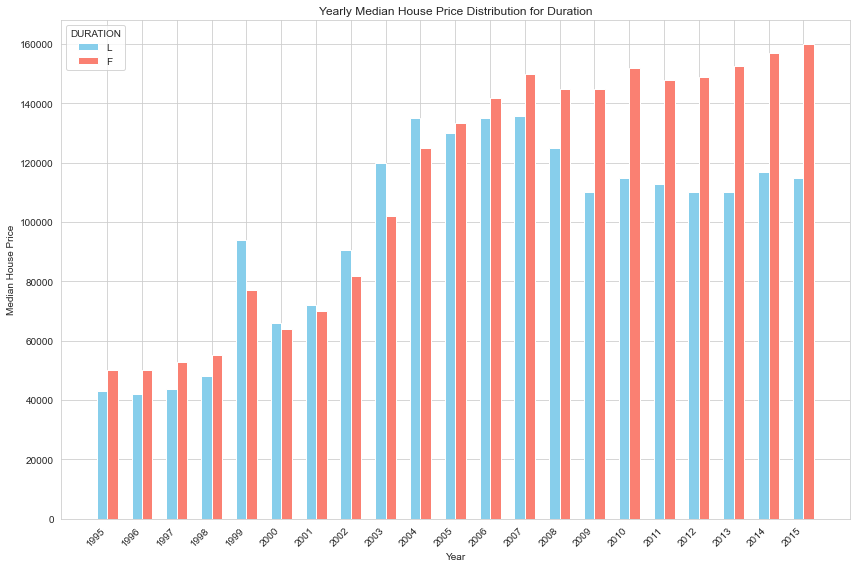

Yearly Median House Price Distribution for Duration


In [17]:
# Calculate the median house price for each year and duration category
median_prices = df.groupby(['Year', 'DURATION'])['PRICE'].median().unstack().reset_index()

# Set plot style
sns.set_style("whitegrid")

# Set the width of each bar
bar_width = 0.3

# Create an array of year indices for positioning bars
years = np.arange(len(median_prices['Year']))

# Plotting the distribution based on median house prices for duration yearly
plt.figure(figsize=(12, 8))

# Plot bars for 'L' duration
plt.bar(years - bar_width/2, median_prices[1], width=bar_width, color='skyblue', label='L')

# Plot bars for 'F' duration
plt.bar(years + bar_width/2, median_prices[0], width=bar_width, color='salmon', label='F')

# Plotting the distribution based on median house prices for duration yearly

plt.xlabel('Year')
plt.ylabel('Median House Price')
plt.title('Yearly Median House Price Distribution for Duration')
plt.xticks(years, median_prices['Year'], rotation=45, ha='right')  # Rotate x-axis labels for better visibility if needed
plt.legend(title='DURATION')
plt.tight_layout()
plt.show()

print ('Yearly Median House Price Distribution for Duration')

In [18]:
#Apply Categorical encoding
df['TOWN/CITY'] = df['TOWN/CITY'].factorize()[0].astype('float32')

df.head()

,PRICE,OLD/NEW,DURATION,TOWN/CITY,DISTRICT,COUNTY,Year,Month,Property_Type__D,Property_Type__F,Property_Type__S,Property_Type__T
0,48950,0,0,0.0,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
1,95950,1,0,1.0,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
2,58000,0,0,2.0,LEEDS,WEST YORKSHIRE,1995,1,0,0,1,0
3,83950,1,0,1.0,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0
4,332500,0,0,1.0,LEEDS,WEST YORKSHIRE,1995,1,1,0,0,0


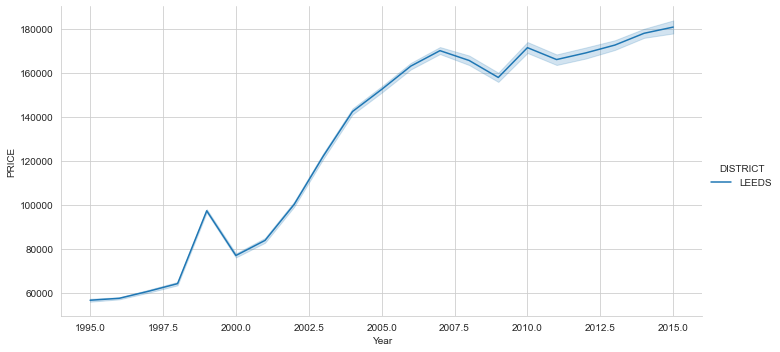

Price Variation per District


In [19]:
sns.relplot(kind = 'line', data = df, x = 'Year', y = 'PRICE', 
            hue = 'DISTRICT', aspect = 2)
plt.show()
print('Price Variation per District')

In [20]:
df.drop(columns = "DISTRICT", axis =1, inplace = True)
df.drop(columns = "COUNTY", axis =1, inplace = True)

In [21]:
#Convert Price column to all numeric
if not pd.api.types.is_numeric_dtype(df['PRICE']):

    df['PRICE'] = df['PRICE'].str.replace('£', '').str.replace(',', '')
    df['PRICE'] = pd.to_numeric(df['PRICE'])

In [22]:
skew_value = df['PRICE'].skew()
print(f"Skewness of 'PRICE': {skew_value}")
if skew_value < 0:
    print("The distribution is left-skewed.")
elif skew_value > 0:
    print("The distribution is right-skewed.")
else:
    print("The distribution is approximately normal.")

Skewness of 'PRICE': 3.762929751743386
The distribution is right-skewed.


In [23]:
log_transform_price = np.log(df["PRICE"])

df['PRICE'] = log_transform_price

print('New skewness:', log_transform_price.skew())
if skew_value < 0:
    print("The distribution is left-skewed.")
elif skew_value > 0:
    print("The distribution is right-skewed.")
else:
    print("The distribution is approximately normal.")

New skewness: -0.14771622821110947
The distribution is right-skewed.


In [24]:
print(df.shape)

(273692, 10)


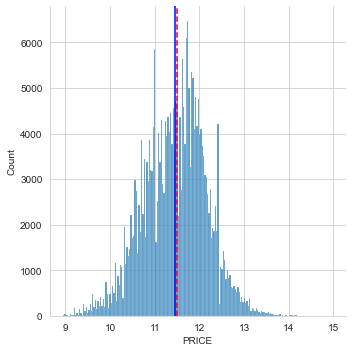

The distribution is right-skewed.


In [25]:
df_mean = df['PRICE'].mean()
df_median = df['PRICE'].median()

sns.displot(data = df, x = 'PRICE')
plt.axvline(x = df_mean, color = 'blue')
plt.axvline(x = df_median, color = "red", linestyle = '--')
plt.show()

if skew_value < 0:
    print("The distribution is left-skewed.")
elif skew_value > 0:
    print("The distribution is right-skewed.")
else:
    print("The distribution is approximately normal.")

#This code helps you visualize the distribution of prices in your data, 
#along with its central tendency represented by the mean and median. 
#By visually comparing the mean and median lines, you can get 
#a sense of how skewed the distribution might be and whether 
#the average price is representative of most values.

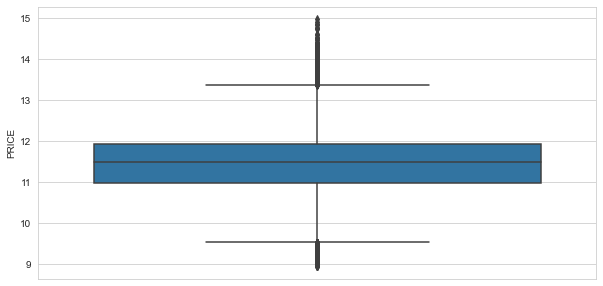

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data = df, y = 'PRICE')
plt.show()

In [27]:
#initialize outliers boundaries and handle outliers
lower = 9.6
higher = 13.3

In [28]:
price_outliers_below = df.loc[df['PRICE'] < lower]
price_outliers_abow = df.loc[df['PRICE'] > higher]

print(price_outliers_below['PRICE'].count(), "entries having 'Price' value lower than ", lower)
print(price_outliers_abow['PRICE'].count(), "entries having 'Price' value greater than", higher)

1784 entries having 'Price' value lower than  9.6
1144 entries having 'Price' value greater than 13.3


In [29]:
lower = 9.6
higher = 13.3

price_mean = df['PRICE'].mean()

df['PRICE'] = df['PRICE'].where(df['PRICE'] >= lower, lower)

df['PRICE'] = df['PRICE'].where(df['PRICE'] <= higher, higher)

df['PRICE'].fillna(price_mean, inplace=True)

price_outliers_below = df[df['PRICE'] < lower]
price_outliers_above = df[df['PRICE'] > higher]

print(f"{price_outliers_below['PRICE'].count()} entries having 'Price' value lower than {lower}")
print(f"{price_outliers_above['PRICE'].count()} entries having 'Price' value greater than {higher}")

0 entries having 'Price' value lower than 9.6
0 entries having 'Price' value greater than 13.3


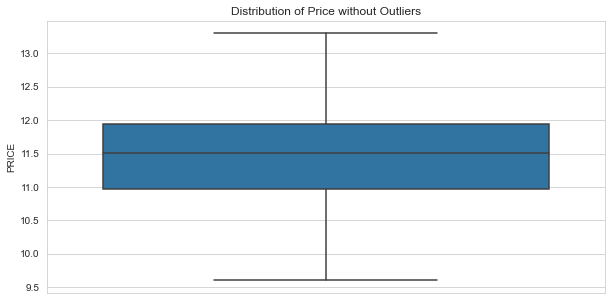

In [30]:
# Plot the distribution of PRICE without outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='PRICE', showfliers=False)
plt.title('Distribution of Price without Outliers')
plt.show()


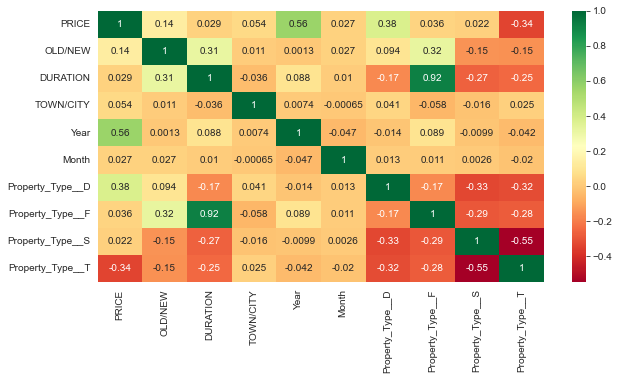

Heatmap with Correlation


In [31]:
#Heatmap with correlations
plt.figure(figsize=(10, 5))
sns.heatmap(df[df.corr().index].corr(), annot = True, cmap = 'RdYlGn')
plt.show()
print('Heatmap with Correlation')

In [32]:
df

,PRICE,OLD/NEW,DURATION,TOWN/CITY,Year,Month,Property_Type__D,Property_Type__F,Property_Type__S,Property_Type__T
0,10.798555,0,0,0.0,1995,1,0,0,1,0
1,11.471583,1,0,1.0,1995,1,1,0,0,0
2,10.968198,0,0,2.0,1995,1,0,0,1,0
3,11.337977,1,0,1.0,1995,1,1,0,0,0
4,12.714395,0,0,1.0,1995,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
273687,11.407565,0,0,1.0,2015,8,0,0,0,1
273688,11.775290,0,0,1.0,2015,8,0,0,1,0
273689,12.301383,0,0,2.0,2015,8,0,0,1,0
273690,12.066811,0,0,1.0,2015,8,0,0,0,1


In [33]:
# Sort data by year (assuming a column named 'Year' contains the year information)
df.sort_values(by='Year', inplace=True)

In [34]:
# Split data into features and target variable
X = df.drop('PRICE', axis=1)
y = df['PRICE']

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
#Define and train the Gradient Boosting Regressor model
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=3)
model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200)

In [37]:
# Evaluate model performance (on test set)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error (MSE): 0.18757674287043152
Root Mean Squared Error (RMSE): 0.4331013078604491
R-squared (R2) Score: 0.6170765276896222


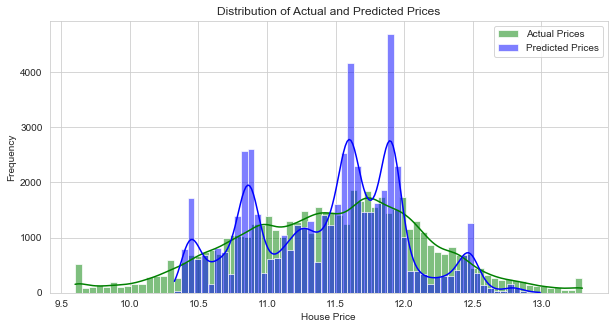

In [38]:
# Plot 1: Distribution of Actual and Predicted Prices
plt.figure(figsize=(10, 5))
sns.histplot(y_test, kde=True, color='green', label='Actual Prices')
sns.histplot(y_pred, kde=True, color='blue', label='Predicted Prices')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted Prices')
plt.legend()
plt.show()


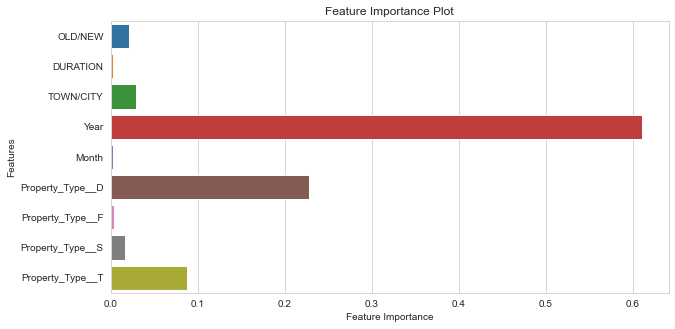

In [39]:
# Compute feature importance
feature_importance = model.feature_importances_
features = X.columns

# Plot 2: Feature Importance Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

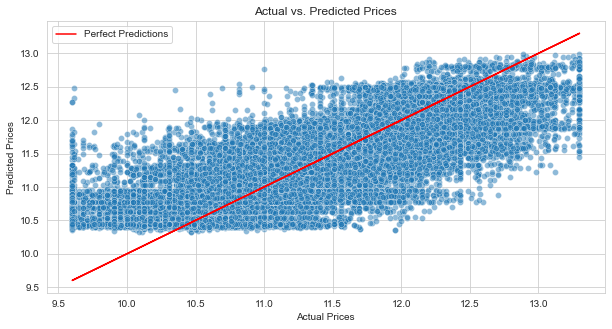

In [40]:
# Plot 3: Scatter Plot of Actual vs. Predicted Prices
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot(y_test, y_test, color='red', label='Perfect Predictions')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

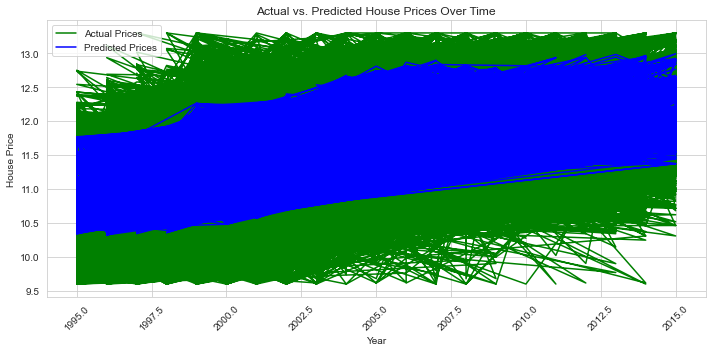

In [41]:
# Plot 4: Time Series Plot of Actual vs. Predicted Prices Over Time
plt.figure(figsize=(10, 5))
plt.plot(X_test['Year'], y_test, label='Actual Prices', color='green')
plt.plot(X_test['Year'], y_pred, label='Predicted Prices', color='blue')
plt.xlabel('Year')
plt.ylabel('House Price')
plt.title('Actual vs. Predicted House Prices Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Selecting features and target variable
features = ['Year', 'Property_Type__D', 'Property_Type__F', 'Property_Type__S', 'Property_Type__T']
X_train = df[features]
y_train = df['PRICE']

# Create and fit the GradientBoostingRegressor model
model_clf = GradientBoostingRegressor()
model_clf.fit(X_train, y_train)

def predict_price(Property_Type, Year, model_clf):
    # Prepare input features in the correct order
    input_features = pd.DataFrame([[Year] + Property_Type], columns=features)
    # Predict the price based on the provided Property_Type
    predicted_price = model_clf.predict(input_features)[0]
    return predicted_price

# Get user input for Property_Type
Property_Type = input("Enter the Property Type (D, F, S, T): ")

# Predefined year for prediction
Year = 2024


# Validate input Property_Type
property_mapping = {'D': [1, 0, 0, 0], 'S': [0, 1, 0, 0], 'F': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}

if Property_Type not in property_mapping:
    print("Invalid Property Type entered.")
else:
    Property_Type_encoded = property_mapping[Property_Type]  # Get the encoded value

    # Predict the price using the prepared data and trained model
    predicted_price = predict_price(Property_Type_encoded, Year, model_clf)
    
    # Calculate antilog using math.exp() function
    predicted_price_antilog = np.exp(predicted_price)

    # Format the predicted price
    formatted_price = "{:,.0f}".format(predicted_price_antilog)  # Assuming predicted price is in thousands
    print("Predicted Price:", formatted_price)


Enter the Property Type (D, F, S, T): D
Predicted Price: 285,934
